In [ ]:
!pip install torchinfo

In [ ]:
import os
import io
import socket
import random
import torch
import torch.nn as nn
import torch.optim as optim
import tensorboard as tb
import torchinfo
import numpy as np
import pandas as pd
import polars as pl
import tabulate
import datasets
import torchvision as tv
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import PIL
import ipywidgets
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm
import logging

from dataclasses import dataclass
from typing import ClassVar

from pathlib import Path
from torch.optim import Adam
from torchvision.transforms import v2
from torchvision import transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, get_dataset_config_names, Dataset, Image, DatasetInfo
from datetime import datetime
from PIL import Image as PILImage, ImageFont, ImageDraw
from collections import Counter
from torchinfo import summary
from typing import List, Dict, Any, Tuple, Optional
from datasets import load_dataset


In [ ]:
writer = SummaryWriter(log_dir="runs/lenet_mnist")


In [ ]:
EPOCHS = 20 # Количество эпох
BATCH_SIZE = 32 # Размер выборки (пакета)
LEARNING_RATE = 1e-4 # Скорость обучения
ROUND_ACC = 2 # Знаков Accuracy после запятой
ROUND_LOSS = 7 # Знаков Loss после запятой
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_hyperparams = {
    "Гиперпараметр": [
        "Количество эпох", "Размер выборки (пакета)", "Скорость обучения",
        "Знаков Accuracy после запятой", "Знаков Loss после запятой",
        "Устройство для обучения"
    ],
    "Значение": [
        str(EPOCHS), BATCH_SIZE, LEARNING_RATE, ROUND_ACC, ROUND_LOSS, DEVICE
    ]
}

In [ ]:
dataset = load_dataset("mnist")

def preprocess(batch):
    imgs = []

    for img in batch["image"]:
        img = np.array(img, dtype=np.uint8)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float() / 255.0
        img = T.Normalize((0.1307,), (0.3081,))(img)
        imgs.append(img)

    batch["image"] = torch.stack(imgs)
    batch["label"] = torch.tensor(batch["label"])
    return batch

dataset.set_transform(preprocess)

README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
train_loader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset["test"],
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y

In [ ]:
model = LeNet(in_channels=1).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(model, loader, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for step, batch in enumerate(loader):
        x = batch["image"].to(DEVICE)
        y = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        if step % 100 == 0:
            writer.add_scalar("Train/BatchLoss", loss.item(), epoch * len(loader) + step)

    acc = correct / total
    avg_loss = total_loss / len(loader)

    writer.add_scalar("Train/Loss", avg_loss, epoch)
    writer.add_scalar("Train/Accuracy", acc, epoch)

    return avg_loss, acc


In [ ]:
def test(model, loader, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(DEVICE)
            y = batch["label"].to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    avg_loss = total_loss / len(loader)

    writer.add_scalar("Test/Loss", avg_loss, epoch)
    writer.add_scalar("Test/Accuracy", acc, epoch)

    return avg_loss, acc

In [ ]:
best_acc = 0.0

In [ ]:
def save_best(model, acc, path="best_lenet.pth"):
    global best_acc
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), path)

In [ ]:
logs = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, epoch)

    test_loss, test_acc = test(model, test_loader, epoch)

    save_best(model, test_acc)
    logs["train_loss"].append(train_loss)
    logs["test_loss"].append(test_loss)
    logs["train_acc"].append(train_acc)
    logs["test_acc"].append(test_acc)
    print(
        f"Epoch {epoch+1}: "
        f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}"
    )


Epoch 1: train_acc=0.9963, test_acc=0.9900
Epoch 2: train_acc=0.9977, test_acc=0.9878
Epoch 3: train_acc=0.9972, test_acc=0.9889
Epoch 4: train_acc=0.9974, test_acc=0.9890
Epoch 5: train_acc=0.9980, test_acc=0.9900
Epoch 6: train_acc=0.9978, test_acc=0.9873
Epoch 7: train_acc=0.9977, test_acc=0.9901
Epoch 8: train_acc=0.9976, test_acc=0.9870
Epoch 9: train_acc=0.9977, test_acc=0.9895
Epoch 10: train_acc=0.9979, test_acc=0.9866
Epoch 11: train_acc=0.9980, test_acc=0.9893
Epoch 12: train_acc=0.9979, test_acc=0.9890
Epoch 13: train_acc=0.9981, test_acc=0.9896
Epoch 14: train_acc=0.9975, test_acc=0.9890
Epoch 15: train_acc=0.9984, test_acc=0.9888
Epoch 16: train_acc=0.9981, test_acc=0.9885
Epoch 17: train_acc=0.9981, test_acc=0.9911
Epoch 18: train_acc=0.9983, test_acc=0.9903
Epoch 19: train_acc=0.9980, test_acc=0.9896
Epoch 20: train_acc=0.9982, test_acc=0.9880


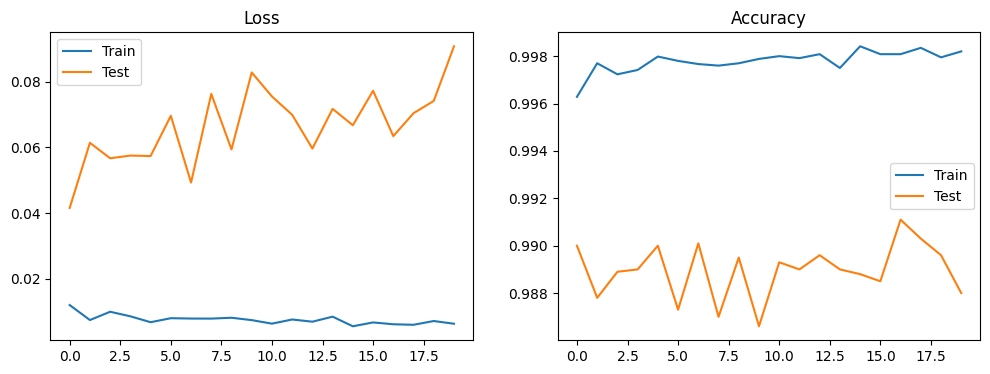

In [ ]:
def plot_metrics(logs):
    epochs = range(len(logs["train_acc"]))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, logs["train_loss"], label="Train")
    plt.plot(epochs, logs["test_loss"], label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, logs["train_acc"], label="Train")
    plt.plot(epochs, logs["test_acc"], label="Test")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

plot_metrics(logs)

In [ ]:
def visualize_predictions(model, loader, epochs=8):
    model.eval()

    batch = next(iter(loader))
    if isinstance(batch, tuple):
        x, y = batch
    elif isinstance(batch, dict):
        x = batch["image"]
        y = batch["label"]

    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)

    x = x.cpu()
    y = y.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12, 4))
    num_samples = x.shape[0]

    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)

        if x[i].shape[0] == 1:
            plt.imshow(x[i][0], cmap="gray")
        else:
            plt.imshow(x[i].permute(1, 2, 0))

        is_correct = preds[i] == y[i]
        color = "green" if is_correct else "red"

        plt.title(
            f"Pred: {preds[i].item()}\n"
            f"True: {y[i].item()}",
            color=color,
            fontsize=10
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
model = LeNet().to(DEVICE)
model.load_state_dict(torch.load("best_lenet.pth", map_location=DEVICE))
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

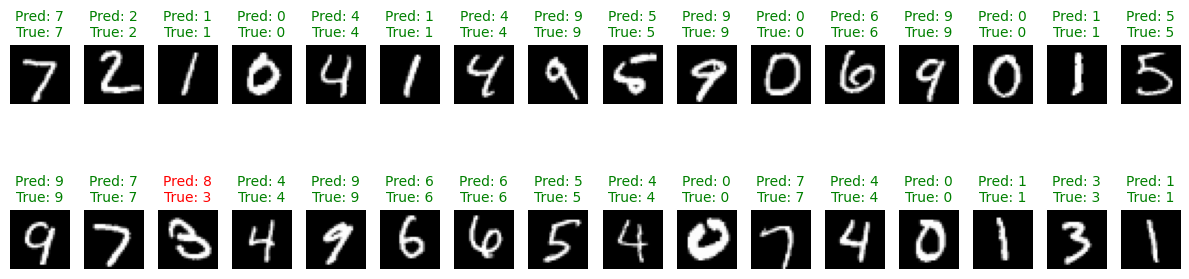

In [ ]:
visualize_predictions(model, test_loader)

# Вывод
LeNet хорошо справляется с задачей детекции цифр в MNIST